# Marimba Model Fitting / Calibration

This notebook contains some example code to fit a marimba model onto a set of random hits with audio feedback.

We optimize the spatial transformation matrix based on previously collected data.

In [479]:
import math
import numpy as np
from scipy.optimize import least_squares

import matplotlib.pyplot as plt
%matplotlib inline

In [480]:
# Create evenly spaced bars on the marimba (should be taken from urdf in the future)
def generate_marimba_model(num_bars, key_length, key_width):
    # Create evenly spaced keys using NumPy's linspace function
    keys = np.linspace(0, key_width * num_bars, num=num_bars)

    # Create lines based on the key points 
    lines = np.zeros((num_bars, 2, 3))
    lines[:, :, 0] = keys[:, None]
    lines[:, 1, 1] = key_length
    
    return lines

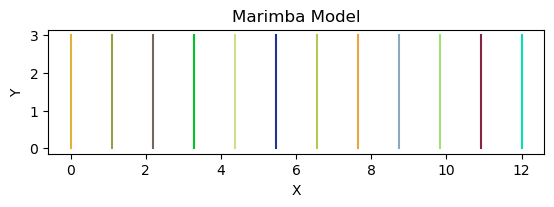

In [482]:
# Plot a given marimba model as seen from the world frame
def plot_model(model, colors=None):
    # Handle default case
    if colors is None:
        colors = np.random.rand(len(model), 3)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add bars to plot
    for i, bar in enumerate(model):
        xs = bar[:,0]
        ys = bar[:,1]
        ax.plot(xs, ys, c=colors[i])

    # Set the axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Marimba Model')
    
    # Set the aspect ratio to 'equal' for all axes
    ax.set_aspect('equal')

model = generate_marimba_model(12, 3, 1)
plot_model(model)

In [483]:
# Creates a transformation matrix based on a rotation (radians) and translation
def get_transformation(rotation_angle, translation):
    cos_theta = np.cos(rotation_angle)
    sin_theta = np.sin(rotation_angle)
    return np.array([[cos_theta, -sin_theta, translation[0]],
                  [sin_theta, cos_theta, translation[1]],
                  [0, 0, 1]])

# Transforms the bars of the marimba model according to a given transformation matrix in a vectorized way
def transform_model(lines, T):
    # Extract the rotation and translation components from the transformation matrix
    R = T[:2, :2]
    t = np.hstack((T[:2, 2], [0]))
    
    # Apply the rotation to the model
    rotated_model = np.einsum('ijk,lk->ijl', lines, T)
    
    # Apply the translation to the rotated model
    translated_model = rotated_model + t.reshape((1, 1, 3))
    
    return translated_model



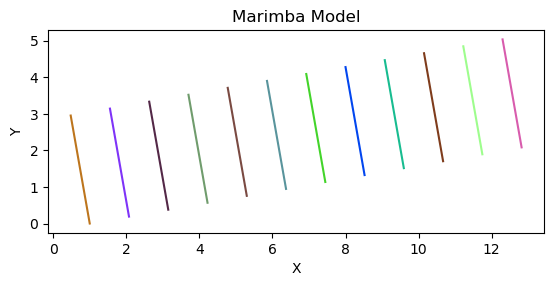

In [484]:
# Test the rotation and translation capabilities
T = get_transformation(math.radians(10), [1, 0])
model_t = transform_model(model, T) 
plot_model(model_t)

In [334]:
# Associate each observed point with the closest bar of the marimba
def associate_points_with_lines(observed_points, transformed_lines):
    
    line_starts = transformed_lines[:, 0]
    line_ends = transformed_lines[:, 1]

    # Calculate direction vectors of line segments
    line_directions = line_ends - line_starts

    # Calculate vector from line start points to each point
    point_vectors = observed_points[:, np.newaxis] - line_starts

    # Calculate perpendicular distances from points to lines
    distances = np.linalg.norm(np.cross(line_directions, point_vectors), axis=2) / np.linalg.norm(line_directions, axis=1)

    # Get index of best matching bar on the marimba for each point
    indices = np.argmin(distances, axis=1)
    
    return indices

[[ 1. -0. -2.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
(30, 12)


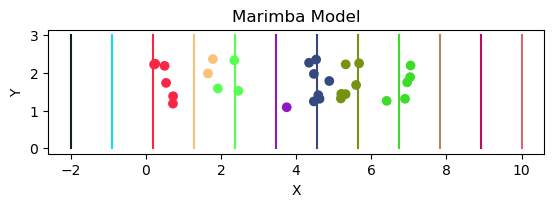

In [494]:
# Create demo transformation, which we want to estimate later on 
T = get_transformation(math.radians(0), [-2,0])
print(T)
# Create move model to this configuration
model_t = transform_model(model, T)

# Sample colors for all Notes
colors = np.random.rand(len(model_t), 3)

# Plot ground truth model
plot_model(model_t, colors)

# Sample positions we want to probe
num_points = 30
observed_points = np.array([
    np.random.uniform(low=0, high=8, size=num_points),
    np.random.uniform(low=1, high=2.5, size=num_points),
    np.zeros(num_points)]).T

# Get the closest note for each of the samples to simulate detections from the audio component
indices = associate_points_with_lines(observed_points, model_t)

# Plot points with color indicating the note
plt.scatter(observed_points[:, 0], observed_points[:, 1], c=colors[indices])

# Set the aspect ratio to 'equal' for all axes
ax.set_aspect('equal')

Estimated rotation: -1.01
Estimated translation: X -1.97 | Y 0.32

Rotation matrix:
[[ 0.99984425  0.01764865 -1.96553235]
 [-0.01764865  0.99984425  0.32255475]
 [ 0.          0.          1.        ]]

Optimized Model:


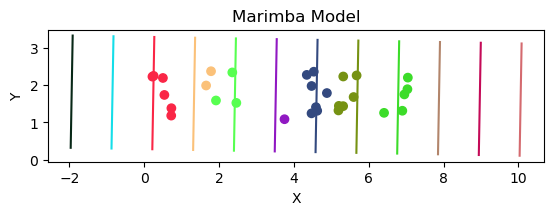

In [495]:
# Define objective function for our optimization
def objective_func(params, points, model):
    # Create transformation based on the parameter set
    transformation = get_transformation(params[2], params[:2])
    
    # Transform model
    model_transformed = transform_model(model, transformation)
    
    # Get the distance from the base line of the note (main cost)
    line_starts = model_transformed[:, 0]
    line_ends = model_transformed[:, 1]
    # Calculate direction vectors of line segments
    line_directions = line_ends - line_starts
    # Calculate vector from line start points to each point
    point_vectors = points - line_starts
    # Calculate perpendicular distances from points to lines
    perp_distances = np.linalg.norm(np.cross(line_directions, point_vectors), axis=1) / np.linalg.norm(line_directions, axis=1)

    # Add small penalty for a large distance from the center of the note
    perp_distances += 0.1 * np.linalg.norm((line_starts + line_ends)/2 - points, axis=1)
    # Add a small penalty for large parameters
    perp_distances += 0.01 * abs(params[2])
    
    return perp_distances


# Define the initial guess for the optimization parameters
initial_guess = np.zeros(3)

# Perform the optimization using the Levenberg-Marquardt algorithm
result = least_squares(
    objective_func, 
    initial_guess, 
    args=(observed_points, 
          model[indices]))

# Extract the optimized translation and rotation parameters
translation = result.x[:2]
rotation = result.x[2]

print(f"Estimated rotation: {math.degrees(rotation):0.2f}")
print(f"Estimated translation: X {translation[0]:0.2f} | Y {translation[1]:0.2f}")

transformation_matrix = get_transformation(rotation, translation)

print("\nRotation matrix:")
print(transformation_matrix)

print("\nOptimized Model:")

plot_model(transform_model(model, transformation_matrix), colors)

# plot points with color based on distance
plt.scatter(observed_points[:, 0], observed_points[:, 1], c=colors[indices])

# Set the aspect ratio to 'equal' for all axes
ax.set_aspect('equal')
